In [51]:
!pip install pandas
!pip install numpy
!pip install joblib
!pip install matplotlib
!pip install scikit-learn


In [52]:
import numpy as np
import pandas as pd
import joblib
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [53]:
warnings.filterwarnings('ignore')

In [54]:
# === Step 1: Load and preprocess dataset ===
df = pd.read_csv("KFD_399.csv")

In [55]:
df_info = df.info()
df_head = df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Season               399 non-null    object
 1   GPS_loc              399 non-null    object
 2   Occupation           399 non-null    object
 3   sudden chills        399 non-null    object
 4   headache             399 non-null    object
 5   severe myalgia       399 non-null    object
 6   fever                399 non-null    object
 7   joint pain           399 non-null    object
 8   neck pain            399 non-null    object
 9   cough                399 non-null    object
 10  diarhoea             399 non-null    object
 11  vomiting             399 non-null    object
 12  photophobia          399 non-null    object
 13  bloody nose          399 non-null    object
 14  bloody gum           399 non-null    object
 15  blood in stool       399 non-null    object
 16  Blood in

In [56]:
df_info, df_head

(None,
   Season GPS_loc Occupation sudden chills headache severe myalgia fever  \
 0      P       P          P             Y        Y              Y     Y   
 1      P       P          N             Y        N              N     N   
 2      P       P          N             N        Y              N     N   
 3      P       P          N             N        N              Y     N   
 4      P       P          N             N        N              N     Y   
 
   joint pain neck pain cough  ... blood in stool Blood in cough  \
 0          Y         Y     Y  ...              Y              Y   
 1          N         N     N  ...              N              N   
 2          N         N     N  ...              N              N   
 3          N         N     N  ...              N              N   
 4          N         N     N  ...              N              N   
 
   blood in vomit red eye neck stiffness mental disturbances giddiness  \
 0              Y       Y              Y           

In [57]:
# Convert Y/N to 1/0
yn_columns = df.columns[3:-1]
for col in yn_columns:
    df[col] = df[col].map({'Y': 1, 'N': 0})


In [58]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Season', 'GPS_loc', 'Occupation'], drop_first=True)


In [59]:
# Convert multi-class labels
df['KFD'] = df['KFD'].map({'C': 0, 'S': 1, 'N': 2, 'PR': 3})
df.dropna(subset=['KFD'], inplace=True)

In [60]:
# === Step 2: Feature Selection ===
X = df.drop('KFD', axis=1)
y = df['KFD']

In [61]:
def feature_selection(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    return X[selected_features], selected_features

X_selected, selected_features = feature_selection(X, y, k=10)
print("Selected Features:", list(selected_features))

Selected Features: ['sudden chills', 'headache', 'severe myalgia', 'fever', 'neck stiffness', 'unconsciousness', 'low bp', 'Season_P', 'GPS_loc_P', 'Occupation_P']


In [62]:
# === Step 3: Scaling and Splitting ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [63]:
# === Step 4: Train Multiple Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [64]:
results = {}
best_model = None
best_accuracy = 0
best_model_name = ""


Logistic Regression Accuracy: 0.8000


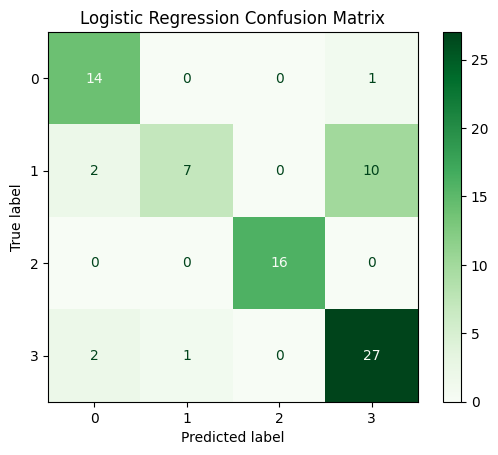


SVM Accuracy: 0.8250


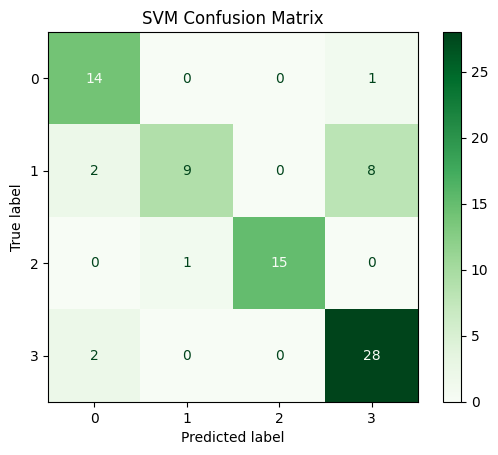


Decision Tree Accuracy: 0.8250


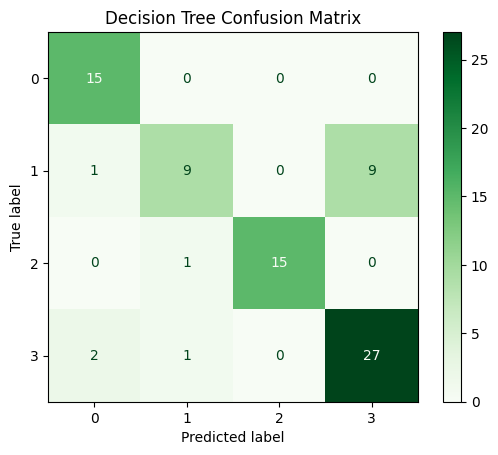


Random Forest Accuracy: 0.7875


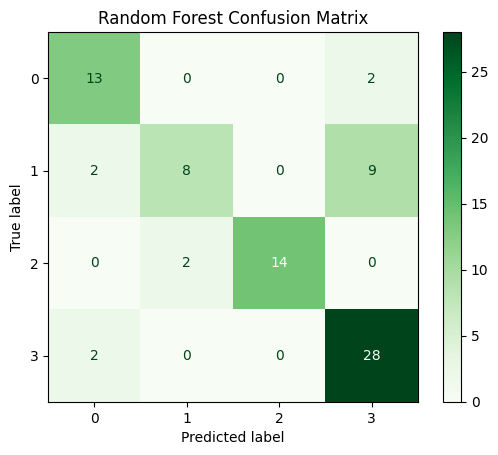

In [65]:
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")

     # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = clf
        best_model_name = name
        best_y_pred = y_pred



In [66]:
# === Step 5: Use Best Model ===
print(f"\n✅ Best Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")
print("\nClassification Report:\n", classification_report(y_test, best_y_pred))


✅ Best Model: SVM (Accuracy: 0.8250)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.90      0.47      0.62        19
           2       1.00      0.94      0.97        16
           3       0.76      0.93      0.84        30

    accuracy                           0.82        80
   macro avg       0.86      0.82      0.82        80
weighted avg       0.84      0.82      0.81        80



In [67]:
# Save the best model, scaler, and selected features
joblib.dump(best_model, "best_kfd_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selected_features.tolist(), "selected_features.pkl")

['selected_features.pkl']

In [68]:
#Now save your metrics.json
metrics = {
    "best_model": best_model_name,
    "accuracy":  best_accuracy,
    "classification_report": classification_report(y_test, best_y_pred, output_dict=True)
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("📊 Saved metrics.json")

📊 Saved metrics.json


In [69]:
# === Step 6: Prediction Function ===
def predict_disease(input_features):
    input_scaled = scaler.transform(np.array(input_features).reshape(1, -1))
    prediction = best_model.predict(input_scaled)
    return prediction[0]

In [70]:
# === Step 7: Example Prediction ===
feature_mapping = {
    0: "sudden chills",
    1: "headache",
    2: "severe myalgia",
    3: "fever",
    4: "neck stiffness",
    5: "unconsciousness",
    6: "low bp",
    7: "Season_P",
    8: "GPS_loc_P",
    9: "Occupation_P"
}

In [71]:
class_mapping = {0: 'Confirmed (C)', 1: 'Suspected (S)', 2: 'Negative (N)', 3: 'Probable (PR)'}

In [72]:
new_patient_data = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
predicted_class = predict_disease(new_patient_data)
print(f"\nPredicted Class: {class_mapping[predicted_class]}")

for i, val in enumerate(new_patient_data):
    print(f"{feature_mapping[i]}: {'Present' if val == 1 else 'Absent'}")


Predicted Class: Confirmed (C)
sudden chills: Present
headache: Present
severe myalgia: Present
fever: Present
neck stiffness: Present
unconsciousness: Present
low bp: Present
Season_P: Present
GPS_loc_P: Present
Occupation_P: Absent


In [73]:
new_patient_data = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
predicted_class = predict_disease(new_patient_data)
print(f"\nPredicted Class: {class_mapping[predicted_class]}")

for i, val in enumerate(new_patient_data):
    print(f"{feature_mapping[i]}: {'Present' if val == 1 else 'Absent'}")


Predicted Class: Negative (N)
sudden chills: Present
headache: Present
severe myalgia: Present
fever: Absent
neck stiffness: Absent
unconsciousness: Absent
low bp: Absent
Season_P: Absent
GPS_loc_P: Absent
Occupation_P: Absent


In [74]:
new_patient_data = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
predicted_class = predict_disease(new_patient_data)
print(f"\nPredicted Class: {class_mapping[predicted_class]}")

for i, val in enumerate(new_patient_data):
    print(f"{feature_mapping[i]}: {'Present' if val == 1 else 'Absent'}")


Predicted Class: Suspected (S)
sudden chills: Present
headache: Present
severe myalgia: Present
fever: Present
neck stiffness: Present
unconsciousness: Absent
low bp: Absent
Season_P: Absent
GPS_loc_P: Absent
Occupation_P: Absent


In [75]:
new_patient_data = [1, 1, 1, 1, 0, 0, 0, 1, 1, 0]
predicted_class = predict_disease(new_patient_data)
print(f"\nPredicted Class: {class_mapping[predicted_class]}")
for i, val in enumerate(new_patient_data):
    print(f"{feature_mapping[i]}: {'Present' if val == 1 else 'Absent'}")


Predicted Class: Probable (PR)
sudden chills: Present
headache: Present
severe myalgia: Present
fever: Present
neck stiffness: Absent
unconsciousness: Absent
low bp: Absent
Season_P: Present
GPS_loc_P: Present
Occupation_P: Absent


In [76]:
import joblib
joblib.dump(scaler, 'scaler.pkl')  # After refitting it

['scaler.pkl']